# INFO

This is a simple system for automated scoring of multiple choice tests. Techniques used include perspective transformation, thresholding, contours extraction, part of image extraction with mask

Requirements to work:
- image of the submitted work and right answers have to be provided
- The picture must have captured all 4 edges of the document

ToDos:
- Handle situation when no answer is given
- Handle situation when multiple answers are possible  

*The idea, the example test and much of the code comes from [www.pyimagesearch.com](https://www.pyimagesearch.com/2016/10/03/bubble-sheet-multiple-choice-scanner-and-test-grader-using-omr-python-and-opencv/)*

# Approach

    Step #1: Detect the exam in an image.
    Step #2: Apply a perspective transform to extract the top-down, birds-eye-view of the exam.
    Step #3: Extract the set of coordinate (i.e., the possible answer choices) from the perspective transformed exam.
    Step #4: Sort the coordinates from top-to-bottom and from left-to-right.
    Step #5: Determine the marked (i.e., “bubbled in”) answer for each row.
    Step #6: Lookup the correct answer in the answer key to determine if the user was correct in their choice.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def order_points(pts):
    '''important it is to maintain a consistent ordering of points'''
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [3]:
def four_point_transform(image, pts):
    # Obtain the points
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # Get the maximum width
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # Get the maximum hight
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    ''' 
    Parameters:
    src – Coordinates of quadrangle vertices in the source image. (The 4 edges of the source view)
    dst – Coordinates of the corresponding quadrangle vertices in the destination image.
    (Where this points will go on the dst window)
    '''
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    '''Arguments: 
    * input image, * Transformation Matrix, *Size of the Image'''                            
        
    # return the warped image
    return warped                                

In [4]:
def resize(image, target_width=500.0):
    (h, w, d) = image.shape
    r = target_width / w
    dim = (target_width, int(h * r))
    image = cv2.resize(image, dim)
    
    return image

Image Size: (441, 315, 3)


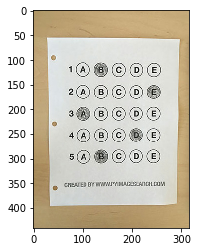

In [5]:
image = cv2.imread('images/test_grading.jpg')
print('Image Size: {}'.format(image.shape))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
plt.show()

In [6]:
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 2, 4: 1}

# Image Transformation

    - Get the Grayscale
    - Apply blurring to reduce high frequency noice
    - Apply Edge Detection
    - Get the countours to extract the document

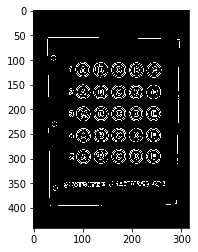

In [7]:
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(grey, (5,5), 0)
edged = cv2.Canny(blur, 75, 200)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_RGB2BGR))
plt.show()

The 4 points are given by the pixel positions:
[[[ 30  55]]

 [[ 34 395]]

 [[289 391]]

 [[295  59]]]


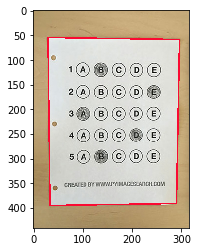

In [8]:
# Get the countors of the paper in order to transform the view
cnts, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
docCnt = None

if len(cnts) > 0:
    # sort the contours according to their size in descending order
    '''in contourArea if a subject is not closed, the area isinstance 
    calculated as a line'''
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    # Loop and approximate the contours / set a 4 edged one to docCnt
    # We want to take an approximation of the contours given by 4 points
    for c in cnts:
        peri = cv2.arcLength(c, True) # computing a closed contour permieter
        # approximating - to reduce the points taken for the contour
        approx = cv2.approxPolyDP(c, 0.15*peri, True)
        
        if len(approx) == 4:
            docCnt = approx
            print('The 4 points are given by the pixel positions:')
            print(docCnt)
            break
            
    img_cont = cv2.drawContours(image, [docCnt], -1, (50, 10, 250), 2)
    plt.imshow(cv2.cvtColor(img_cont, cv2.COLOR_RGB2BGR))
    plt.show()

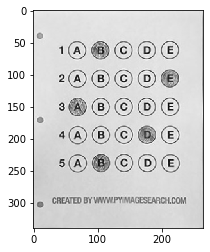

In [9]:
doc_points = docCnt.reshape(4, 2)
paper = four_point_transform(image, doc_points)
wraped = four_point_transform(grey, doc_points)

plt.imshow(cv2.cvtColor(wraped, cv2.COLOR_RGB2BGR))
plt.show()

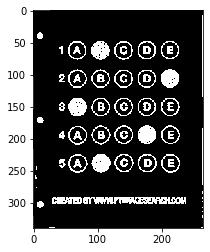

In [10]:
# Thresholding the image in order to get the right answers 
# this dominates with with pixels
thresh = cv2.threshold(wraped, 200, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_RGB2BGR))
plt.show()

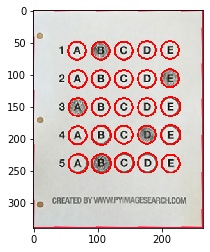

In [11]:
# Getting the contours of the choices
cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
questionCnts = []
circled = paper.copy()

for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    center = (int(x+w/2), int(y+h/2))
    radius = int(w/2)
    
    if w >= 20 and h >=20 and ar >=0.9 and ar <= 1.1:
        questionCnts.append(c)
        
        circled = cv2.circle(circled, center, radius, (0, 0, 255), 2)
        
plt.imshow(cv2.cvtColor(circled, cv2.COLOR_RGB2BGR))
plt.show()

In [12]:
# Sort the contours top-to-bottom
questionCnts = sorted(questionCnts, key=lambda x:x[0][0][1])

In [13]:
# Sort the contours left-to-right
bubble = []
for q in (np.arange(0, len(questionCnts), 5)):
#     print(q,q+5)
    tmp = sorted(questionCnts[q:q+5], key=lambda x:x[0][0][0])
    bubble.append(tmp)

In [14]:
# Base on the Sum of the pixel values within each contour we obtained the marked answer
answers_list = []
for i in range(len(bubble)):
    masked_sum = 0
    marked_answer = 100
    for j, c in enumerate(bubble[i]):
        mask = np.zeros(thresh.shape, dtype='uint8')
        mask = cv2.drawContours(mask, [c], -1, 250, -1)

        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        if mask.sum() > masked_sum:
            masked_sum = mask.sum()
            marked_answer = j

#         print(mask.sum())
#         plt.imshow(cv2.cvtColor(mask, cv2.COLOR_RGB2BGR))
#         plt.show()
#     print(marked_answer, masked_sum)

    answers_list.append(marked_answer)
    
print('Answers List: {}'.format(answers_list))

Answers List: [1, 4, 0, 3, 1]


In [17]:
number_correct = 0
for i in ANSWER_KEY:
    correct_answer = ANSWER_KEY.get(i)
    given_answer = answers_list[i]
    if correct_answer == given_answer:
        number_correct += 1
score = number_correct / len(ANSWER_KEY)
print('The Final Score is {}%'.format(float(score*100)))

The Final Score is 80.0%


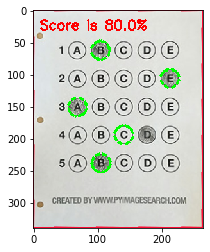

In [22]:
corrected = paper.copy()
for i, j in enumerate(ANSWER_KEY):
    
    correct_answer = ANSWER_KEY.get(j)
    corrected = cv2.drawContours(corrected, bubble[i][correct_answer], -1, (0, 255, 0), 3)

corrected = cv2.putText(corrected, 'Score is {}%'.format(float(score*100)), (10, 30),
    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(corrected, cv2.COLOR_RGB2BGR))
plt.show()